In [1]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC # Will learn more about this later

In [2]:
X, y = make_moons(n_samples=500, random_state=42, noise=0.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Ensemble

Going to aggregate the predictions of each classifier - the class that gets the most votes is the ensemble's predictor.

In [3]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42)),
    ]
)

voting_clf.fit(X_train, y_train)

,estimators,"[('lr', ...), ('rf', ...), ...]"
,voting,'hard'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True


In [6]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, '=', clf.score(X_test, y_test))

lr = 0.85
rf = 0.88
svc = 0.87


In [7]:
voting_clf.predict(X_test[:1])

array([0])

In [8]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([0]), array([1]), array([0])]

In [9]:
voting_clf.score(X_test, y_test) # Same score as svc

0.87

Soft voting gives more weight to highly confident votes. (For SVC class, you need to adjust the voting hyperparameter is 'soft' and ensure classifiers can estimate class probabilities. Since this isn't default, make the adjustment).

In [11]:
voting_clf.voting = 'soft'
voting_clf.named_estimators['svc'].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.89

Simple soft voting has achieved an accuracy of 89%!

## Bagging and Pasting

Using the same training algorithm, but on different random subsets of the training set.
If there's no replacement, then this is **pasting**.

Below I'll train an ensemble of 500 decision tree classifiers, with each trained on 100 instances of randomly sampled training instances with replacement.

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    n_jobs=-1,               # Tells scikit-learn to use all available CPU cores for ensemble
    random_state=42
)

bag_clf.fit(X_train, y_train)

,estimator,DecisionTreeClassifier()
,n_estimators,500
,max_samples,100
,max_features,1.0
,bootstrap,True
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,-1
,random_state,42
,verbose,0


In [13]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


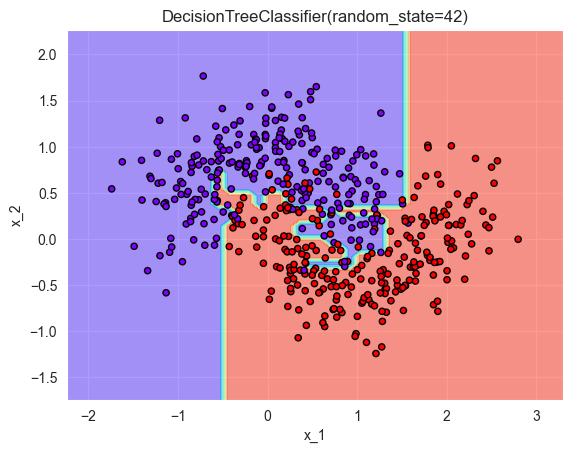

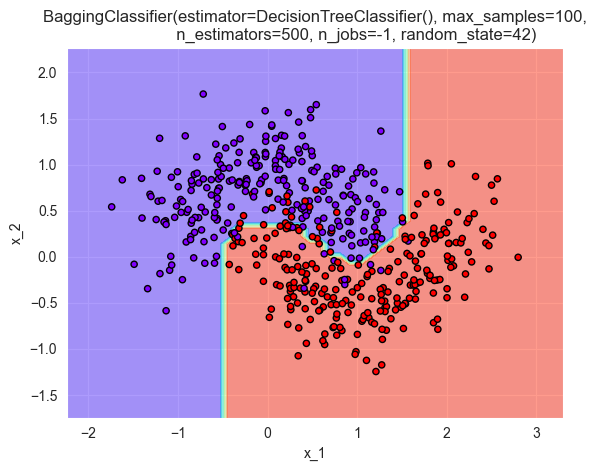

In [17]:
import numpy as np
import matplotlib.pyplot as plt

for model in [tree_clf, bag_clf]:
    x1s = np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
    x2s = np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)

    x1, x2 = np.meshgrid(x1s, x2s) # Turns all of the above points into a grid of coordinates
    X_grid = np.c_[x1.ravel(), x2.ravel()] # np.c_ places these into pairs, with ravel flattening to 1D
    y_pred = model.predict(X_grid).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.5, cmap=plt.cm.rainbow) # Filling grid with colours to show prediction regions
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.rainbow, edgecolors="k", s=20)
    # Overlay of iris samples, colour coded

    plt.xlabel("x_1")
    plt.ylabel("x_2")
    plt.title(f"{model}")
    plt.show()

### Out of Bag Evaluation

By default BaggingClassifier samples m training instances with replacement (m = size of training set). It can, however, be shown that only 63% of the training instances are sampled on average for each predictor, leaving the remaining 37% as **OOB** instances.

In [20]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    n_jobs=-1,
    random_state=42,
    oob_score = True
)

bag_clf.fit(X_train, y_train)
bag_clf.score(X_test, y_test)

0.9

In [24]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
print(f'{accuracy_score(y_test, y_pred):.2f}')

0.90


In [25]:
bag_clf.oob_decision_function_[:3]

array([[0.98670213, 0.01329787],
       [0.01066667, 0.98933333],
       [0.08974359, 0.91025641]])

# Random Forests

Simply an ensemble of decision trees trained using the bagging method.

In [26]:
from sklearn.ensemble import RandomForestClassifier

random_forest_clf = RandomForestClassifier(
    n_estimators=500,
    max_leaf_nodes=16,
    n_jobs=-1,
    random_state=42,
)
random_forest_clf.fit(X_train, y_train)

y_pred = random_forest_clf.predict(X_test)

In [27]:
from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)
random_forest_clf.fit(iris.data, iris.target)

for score, name in zip(random_forest_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)
